In [2]:
import pandas as pd

# proceeded_cctv.csv 불러오기
df = pd.read_csv("../../results/proceeded_cctv.csv", encoding="utf-8-sig")

In [3]:
# 설치목적별 CCTV 수량 합계
purpose_grouped = df.groupby('설치목적')['CCTV 수량'].sum().sort_values(ascending=False)
display(purpose_grouped)


설치목적
생활방범     845
어린이보호    149
교통단속      74
쓰레기단속     56
다목적       26
시설물관리     21
재난재해      11
기타         3
Name: CCTV 수량, dtype: int64

/tmp/ipykernel_3357/4089370299.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=purpose_grouped.index, y=purpose_grouped.values, palette='Blues_d')


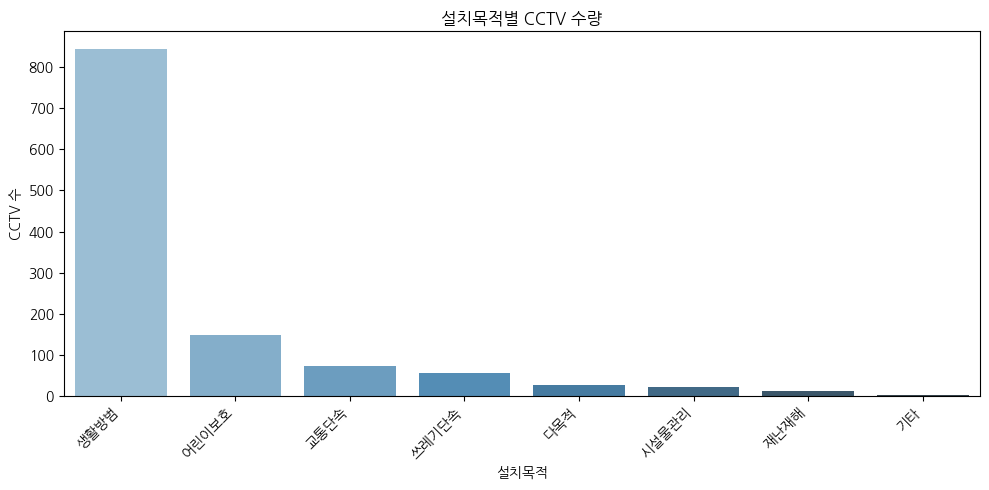

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 한글 폰트 설정 (Linux 기준 나눔고딕 사용)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 5))
sns.barplot(x=purpose_grouped.index, y=purpose_grouped.values, palette='Blues_d')
plt.title("설치목적별 CCTV 수량")
plt.ylabel("CCTV 수")
plt.xlabel("설치목적")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 결과 저장
os.makedirs("../../results", exist_ok=True)
plt.savefig("../../results/cctv_by_purpose.png", dpi=150)
plt.show()


In [8]:
# 📌 단독 설치된 CCTV만 필터링 (CCTV 수량이 1인 경우)
df_solo = df[df['CCTV 수량'] == 1]

# ✅ 단독 설치 CCTV 개수
solo_count = len(df_solo)
print(f"✅ 단독 설치된 CCTV 개수: {solo_count}개")

# ✅ 전체 대비 비율도 같이 볼 수 있음
total_count = len(df)
ratio = solo_count / total_count * 100
print(f"✅ 전체 대비 단독 설치 비율: {ratio:.2f}%")

✅ 단독 설치된 CCTV 개수: 1185개
✅ 전체 대비 단독 설치 비율: 100.00%


In [9]:
# Cluster 항목이 없어 직접 추가했습니다.

# 📘 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

# 📁 2. proceeded_cctv.csv 불러오기
df = pd.read_csv("../../results/proceeded_cctv.csv", encoding="utf-8-sig")

# ✅ 3. 위도/경도 좌표 준비
coords = df[['위도', '경도']].dropna().to_numpy()

# 📏 4. DBSCAN 파라미터 설정
kms_per_radian = 6371.0088  # 지구 반지름
epsilon = 0.1 / kms_per_radian  # 100m 반경 설정
db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine')

# 🛰️ 5. 위경도를 라디안으로 변환 후 클러스터링
df['cluster'] = db.fit_predict(np.radians(coords))

# ✅ 6. 결과 확인
print("✅ 클러스터링 완료!")
print(df['cluster'].value_counts())

# 💾 7. proceeded_cctv_with_cluster.csv로 저장
df.to_csv("../../results/proceeded_cctv_with_cluster.csv", index=False, encoding="utf-8-sig")
print("✅ proceeded_cctv_with_cluster.csv 저장 완료")


✅ 클러스터링 완료!
cluster
0     141
3     141
2     109
11     88
15     87
     ... 
69      2
70      2
71      2
72      2
73      2
Name: count, Length: 75, dtype: int64
✅ proceeded_cctv_with_cluster.csv 저장 완료


In [10]:
# 📘 1. 라이브러리 불러오기
import pandas as pd
import folium
import os

# 📁 2. proceeded_cctv_with_cluster.csv 불러오기
df = pd.read_csv("../../results/proceeded_cctv_with_cluster.csv", encoding="utf-8-sig")

# 🧼 3. 설치목적 및 클러스터 정리
df['설치목적'] = df['설치목적'].astype(str).str.strip()

# 🗺️ 4. 지도 객체 생성 (중심: 평균 위경도)
m = folium.Map(location=[df['위도'].mean(), df['경도'].mean()], zoom_start=13)

# 🎨 5. 클러스터에 따라 색상 지정
def get_marker_color(cluster_label):
    if cluster_label == -1:
        return "red"  # 단독 설치는 빨간색
    else:
        return "blue"  # 군집된 포인트는 파란색

# 📍 6. 마커 추가
for _, row in df.iterrows():
    color = get_marker_color(row['cluster'])
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=3 + row['CCTV 수량'] * 0.5,
        popup=f"{row['주소']} (cluster: {row['cluster']})",
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# 💾 7. 지도 저장
os.makedirs("../../results", exist_ok=True)
output_path = "../../results/cctv_map_with_cluster.html"
m.save(output_path)

print(f"✅ 지도 저장 완료: {output_path}")


✅ 지도 저장 완료: ../../results/cctv_map_with_cluster.html


In [1]:
import pandas as pd
import numpy as np
from haversine import haversine, Unit

# 📁 proceeded_cctv_with_cluster.csv 불러오기
df = pd.read_csv("../../results/proceeded_cctv_with_cluster.csv", encoding="utf-8-sig")

# ✅ 단독 설치 CCTV만 추출
df_solo = df[df['cluster'] == -1].copy()

# ✅ 전체 CCTV 좌표
coords_all = df[['위도', '경도']].to_numpy()

# ✅ 단독 CCTV 주변 친구 수 계산
nearby_counts = []

for _, solo_row in df_solo.iterrows():
    solo_coord = (solo_row['위도'], solo_row['경도'])
    count = 0
    for coord in coords_all:
        dist = haversine(solo_coord, (coord[0], coord[1]), unit=Unit.KILOMETERS)
        if 0 < dist <= 0.1:  # 100m 이내, 자기 자신 제외
            count += 1
    nearby_counts.append(count)

# ✅ 결과 저장
df_solo['주변 CCTV 수'] = nearby_counts

# ✅ 결과 확인
df_solo_sorted = df_solo.sort_values(by='주변 CCTV 수', ascending=False)
display(df_solo_sorted[['주소', '주변 CCTV 수']])

# 💾 저장
df_solo_sorted.to_csv("../../results/solo_cctv_with_nearby_counts.csv", index=False, encoding="utf-8-sig")
print("✅ 주변 친구 수까지 저장 완료: solo_cctv_with_nearby_counts.csv")


,주소,주변 CCTV 수
14,서울특별시 광진구 뚝섬로52라길 61-12 (자양동),0
159,서울특별시 광진구 아차산로58길 77 (구의동),0
163,서울특별시 광진구 아차산로60길 13-13 (구의동),0
256,서울특별시 광진구 긴고랑로5길 10 (중곡동),0
273,서울특별시 광진구 영화사로 11길 39,0
298,서울특별시 광진구 용마도시자연공원-사무실,0
307,서울특별시 광진구 능동로 25-1 (자양동),0
346,서울특별시 광진구 강변역로4길 56 (구의동),0
386,서울특별시 광진구 용마산로21길 77 (중곡동),0
408,서울특별시 광진구 능동로 110 (화양동),0


✅ 주변 친구 수까지 저장 완료: solo_cctv_with_nearby_counts.csv


In [2]:
import pandas as pd
import re

# proceeded_cctv.csv 불러오기
df = pd.read_csv("../../results/proceeded_cctv.csv", encoding="utf-8-sig")

# 숫자가 포함된 설치목적(시설유형)만 필터링
def has_number(text):
    return bool(re.search(r'\d', str(text)))

df_with_numbers = df[df['설치목적'].apply(has_number)]

# 결과 확인
print(f"✅ 숫자 포함된 시설유형 수: {len(df_with_numbers)}개")
display(df_with_numbers[['주소', '설치목적']])

# 저장
df_with_numbers.to_csv("../../results/cctv_with_numbers.csv", index=False, encoding="utf-8-sig")
print("✅ 숫자 포함된 시설유형 파일 저장 완료: cctv_with_numbers.csv")


✅ 숫자 포함된 시설유형 수: 0개


,주소,설치목적


✅ 숫자 포함된 시설유형 파일 저장 완료: cctv_with_numbers.csv


In [4]:
import pandas as pd
import re
import os

# 데이터 불러오기
df = pd.read_csv("../../results/proceeded_cctv.csv", encoding="utf-8-sig")

# 1️⃣ 숫자가 포함된 시설유형만 뽑기
def has_number(text):
    return bool(re.search(r'\d', str(text)))

df_with_numbers = df[df['설치목적'].apply(has_number)].copy()

# 👉 숫자 들어간 시설유형만 따로 저장 (1개째 파일)
output_dir = "../../results"
os.makedirs(output_dir, exist_ok=True)

df_with_numbers.to_csv(f"{output_dir}/cctv_with_numbers_only.csv", index=False, encoding="utf-8-sig")
print("✅ 숫자 포함 시설유형 파일 저장 완료: cctv_with_numbers_only.csv")

# 2️⃣ 시설유형 정제 (숫자 제거 후 동 이름만 남기기)
def extract_dong_name(text):
    if isinstance(text, str):
        match = re.search(r'([가-힣]+)\d', text)
        if match:
            return match.group(1)
    return text

df_with_numbers['정제된동이름'] = df_with_numbers['설치목적'].apply(extract_dong_name)

# 👉 정제된 동이름 버전 따로 저장 (2개째 파일)
df_final = df_with_numbers[['주소', '설치목적', '정제된동이름']]
df_final.to_csv(f"{output_dir}/cctv_with_cleaned_dong.csv", index=False, encoding="utf-8-sig")

print("✅ 숫자 제거된 동이름 파일 저장 완료: cctv_with_cleaned_dong.csv")


✅ 숫자 포함 시설유형 파일 저장 완료: cctv_with_numbers_only.csv
✅ 숫자 제거된 동이름 파일 저장 완료: cctv_with_cleaned_dong.csv


In [5]:
import pandas as pd
import os

# 📁 proceeded_cctv.csv 불러오기
df = pd.read_csv("../../results/proceeded_cctv.csv", encoding="utf-8-sig")

# 📦 저장할 폴더 준비
output_dir = "../../results"
os.makedirs(output_dir, exist_ok=True)

# 1️⃣ Graph.csv 만들기: 설치목적별 CCTV 수량 집계
graph_df = df.groupby('설치목적')['CCTV 수량'].sum().reset_index()
graph_df = graph_df.sort_values(by='CCTV 수량', ascending=False)

graph_csv_path = f"{output_dir}/Graph.csv"
graph_df.to_csv(graph_csv_path, index=False, encoding="utf-8-sig")
print(f"✅ 시설유형별 집계 저장 완료: {graph_csv_path}")

# 2️⃣ analysis.csv 만들기: 주변 친구 수 기반 분석용
analysis_columns = ['주소', '위도', '경도', 'CCTV 수량', '설치목적']
analysis_df = df[analysis_columns]

analysis_csv_path = f"{output_dir}/analysis.csv"
analysis_df.to_csv(analysis_csv_path, index=False, encoding="utf-8-sig")
print(f"✅ 분석용 기본 파일 저장 완료: {analysis_csv_path}")


✅ 시설유형별 집계 저장 완료: ../../results/Graph.csv
✅ 분석용 기본 파일 저장 완료: ../../results/analysis.csv
